In [13]:
!pip install torch torchvision torchaudio
!pip install torch-geometric

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score



In [14]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

datasets = {
    "Cora": Planetoid(root='./CoraData', name='Cora'),
    "Citeseer": Planetoid(root='./CiteseerData', name='Citeseer')
}


In [15]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [16]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [17]:
def train(model, data, optimizer, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    return model

def evaluate(model, data, num_classes):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].cpu()
    y_pred = pred[data.test_mask].cpu()
    
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_score": f1_score(y_true, y_pred, average="macro", zero_division=0)
    }

    y_proba = out[data.test_mask].cpu().detach().numpy()
    y_true_onehot = F.one_hot(data.y[data.test_mask], num_classes=num_classes).cpu().numpy()
    try:
        metrics["auc_roc"] = roc_auc_score(y_true_onehot, y_proba, average="macro", multi_class="ovr")
    except ValueError:
        metrics["auc_roc"] = None 
    return metrics



Results for Cora Dataset:
  GCN -> Accuracy: 0.7970, Precision: 0.7779, Recall: 0.8177, F1-Score: 0.7919, AUC-ROC: 0.962769776263479
  GAT -> Accuracy: 0.7720, Precision: 0.7548, Recall: 0.7890, F1-Score: 0.7635, AUC-ROC: 0.9552159034200157

Results for Citeseer Dataset:
  GCN -> Accuracy: 0.6830, Precision: 0.6600, Recall: 0.6624, F1-Score: 0.6571, AUC-ROC: 0.8860749006669
  GAT -> Accuracy: 0.6890, Precision: 0.6595, Recall: 0.6659, F1-Score: 0.6586, AUC-ROC: 0.8794693162136724


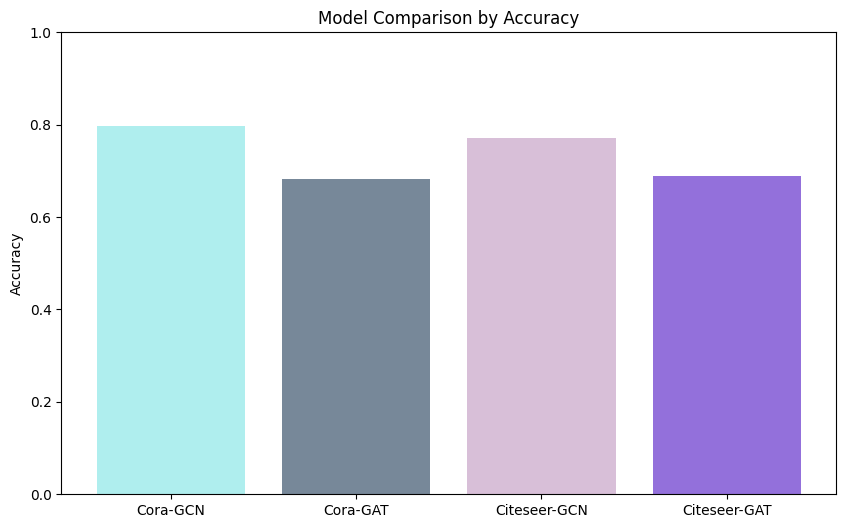

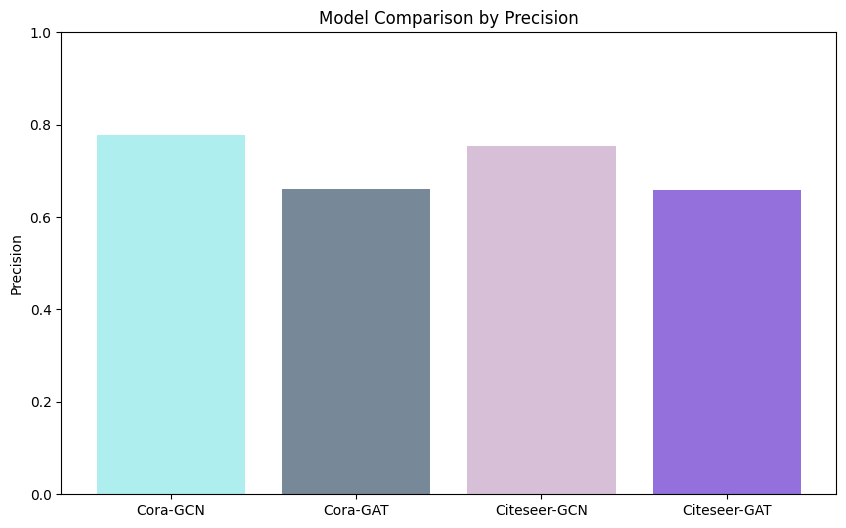

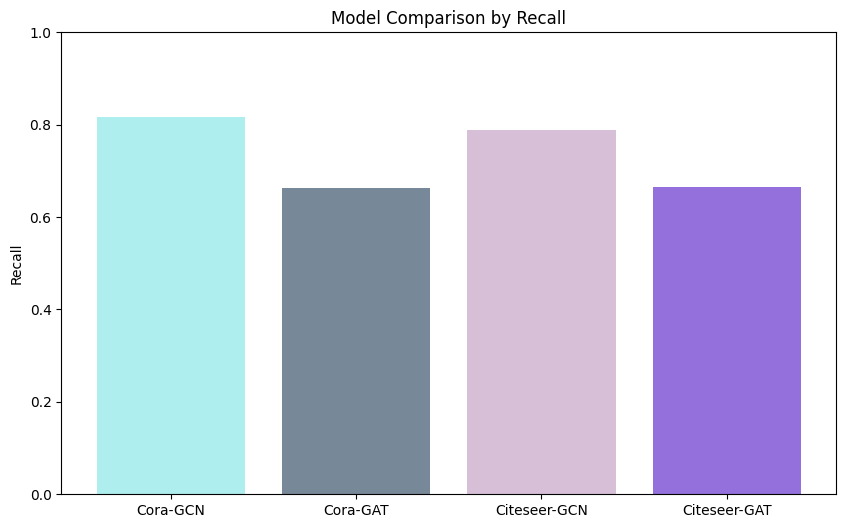

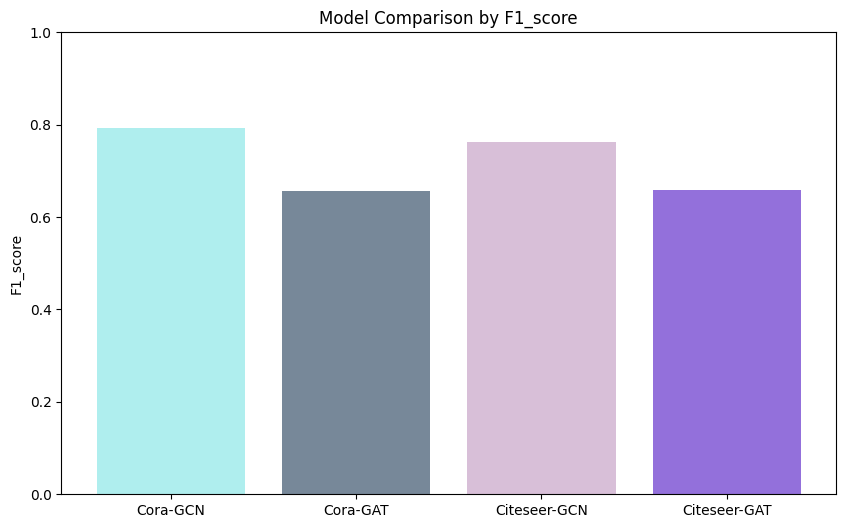

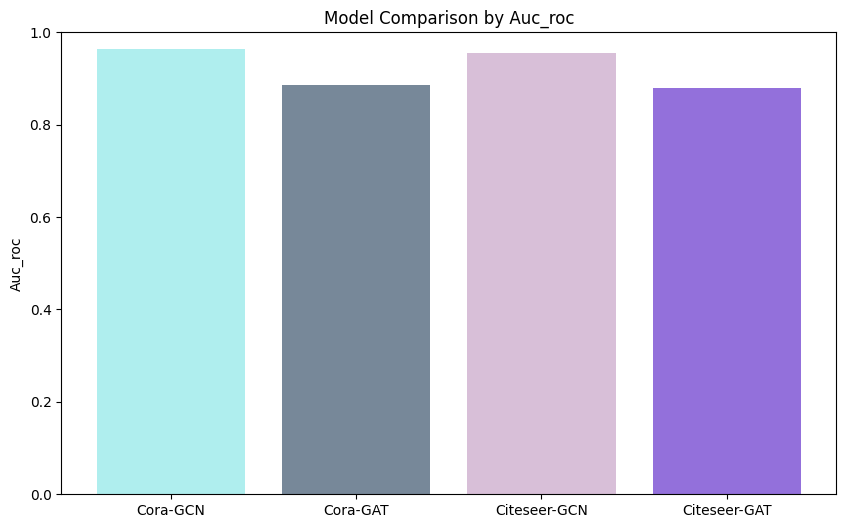

In [25]:
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for dataset_name, dataset in datasets.items():
    data = dataset[0].to(device)
    input_dim = dataset.num_features
    output_dim = dataset.num_classes

    gcn = GCN(input_dim=input_dim, hidden_dim=16, output_dim=output_dim).to(device)
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    gcn = train(gcn, data, optimizer)
    gcn_metrics = evaluate(gcn, data, num_classes=output_dim)

    gat = GAT(input_dim=input_dim, hidden_dim=8, output_dim=output_dim, heads=8).to(device)
    optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)
    gat = train(gat, data, optimizer)
    gat_metrics = evaluate(gat, data, num_classes=output_dim)

    results[dataset_name] = {
        "GCN": gcn_metrics,
        "GAT": gat_metrics
    }

for dataset_name, metrics in results.items():
    print(f"\nResults for {dataset_name} Dataset:")
    for model_name, model_metrics in metrics.items():
        print(f"  {model_name} -> Accuracy: {model_metrics['accuracy']:.4f}, Precision: {model_metrics['precision']:.4f}, Recall: {model_metrics['recall']:.4f}, F1-Score: {model_metrics['f1_score']:.4f}, AUC-ROC: {model_metrics['auc_roc'] if model_metrics['auc_roc'] else 'N/A'}")


for metric in ["accuracy", "precision", "recall", "f1_score", "auc_roc"]:
    gcn_values = [results[dataset]["GCN"][metric] for dataset in results]
    gat_values = [results[dataset]["GAT"][metric] for dataset in results]

    plt.figure(figsize=(10, 6))
    plt.bar(["Cora-GCN", "Cora-GAT", "Citeseer-GCN", "Citeseer-GAT"], gcn_values + gat_values, color=["paleturquoise", "lightslategray", "thistle", "mediumpurple"])
    plt.title(f"Model Comparison by {metric.capitalize()}")
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    plt.savefig(f"{metric}_bar")
    plt.show()


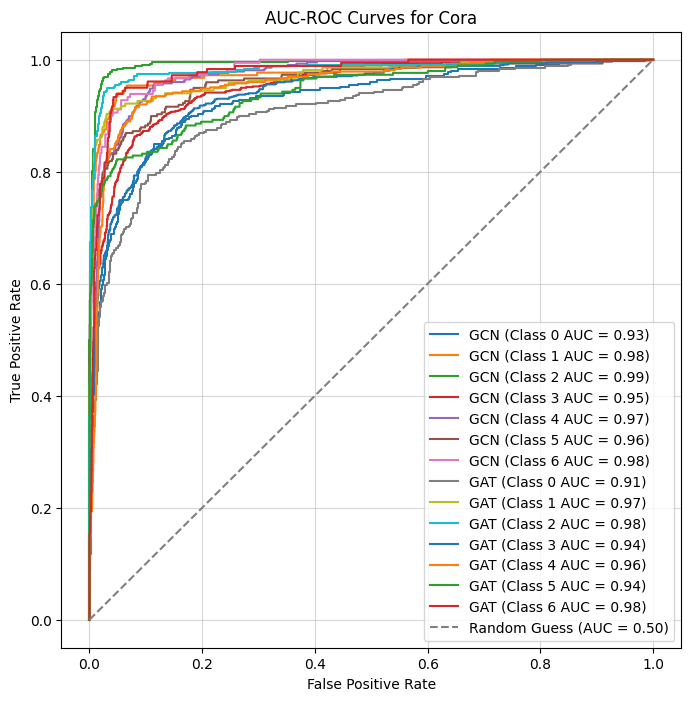

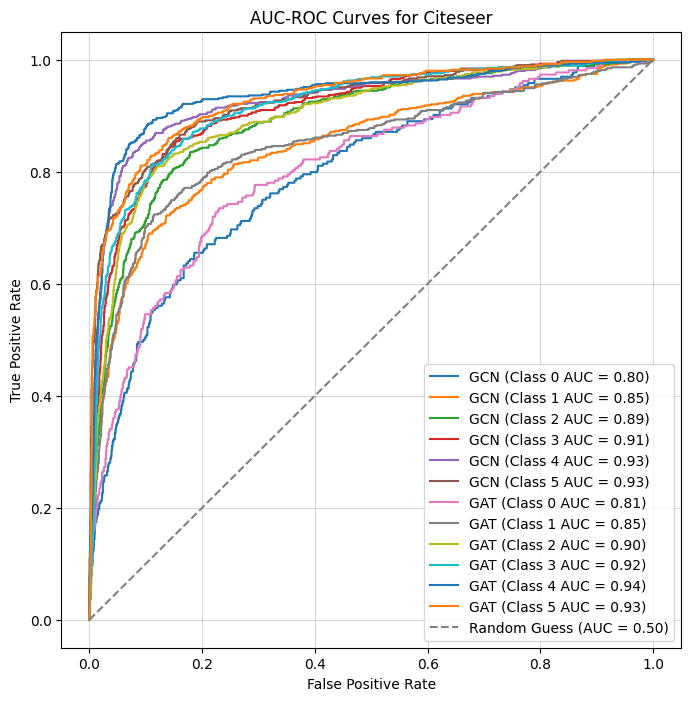

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot AUC-ROC curves
def plot_roc_curves(data, models, dataset_name, num_classes):
    plt.figure(figsize=(8, 8))
    for model_name, model in models.items():
        model.eval()
        logits = model(data).detach().cpu()
        y_true = data.y.cpu()
        y_score = logits.softmax(dim=1).cpu()
        
        # One-vs-Rest for multiclass ROC
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve((y_true == i).numpy(), y_score[:, i].numpy())
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{model_name} (Class {i} AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess (AUC = 0.50)")
    plt.title(f"AUC-ROC Curves for {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.5)
    plt.savefig(f"auc_roc_for_{dataset_name}")
    plt.show()

# Plotting AUC-ROC for Cora and Citeseer datasets
for dataset_name, dataset in datasets.items():
    data = dataset[0].to(device)
    input_dim = dataset.num_features
    output_dim = dataset.num_classes

    # Initialize models
    gcn = GCN(input_dim=input_dim, hidden_dim=16, output_dim=output_dim).to(device)
    gat = GAT(input_dim=input_dim, hidden_dim=8, output_dim=output_dim, heads=8).to(device)
    
    # Train models
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    gcn = train(gcn, data, optimizer)
    
    optimizer = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)
    gat = train(gat, data, optimizer)
    
    

    plot_roc_curves(data, {"GCN": gcn, "GAT": gat}, dataset_name, output_dim)
